# Python for Finance
Testing functions from the Python for Finance book

In [1]:
import bsm_functions as bsm #make sure the bsm_functions.py file is in the same folder as the notebook
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline 

In [2]:
h5 = pd.HDFStore('vstoxx_data_31032014.h5','r')
futures_data = h5['futures_data']
futures_data['DATE'] = futures_data['DATE'].apply(lambda x: pd.to_datetime(x))
futures_data['MATURITY'] = futures_data['MATURITY'].apply(lambda x: pd.to_datetime(x))

options_data = h5['options_data']
options_data['DATE'] = options_data['DATE'].apply(lambda x: pd.to_datetime(x))
options_data['MATURITY'] = options_data['MATURITY'].apply(lambda x: pd.to_datetime(x))

h5.close()

In [3]:
options_data.head()

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM
46170,2014-03-31,2014,4,C,1,16.85,2014-04-18,0.049
46171,2014-03-31,2014,4,C,2,15.85,2014-04-18,0.049
46172,2014-03-31,2014,4,C,3,14.85,2014-04-18,0.049
46173,2014-03-31,2014,4,C,4,13.85,2014-04-18,0.049
46174,2014-03-31,2014,4,C,5,12.85,2014-04-18,0.049


In [4]:
futures_data.head()

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31,2014,4,17.85,2014-04-18,0.049
497,2014-03-31,2014,5,19.55,2014-05-16,0.126
498,2014-03-31,2014,6,19.95,2014-06-20,0.222
499,2014-03-31,2014,7,20.40,2014-07-18,0.299
500,2014-03-31,2014,8,20.70,2014-08-15,0.375


In [5]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null datetime64[ns]
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null datetime64[ns]
TTM          395 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [6]:
# add a column for the implied vol
options_data['IMP_VOL'] = 0.0
V0 = 17.6639
r = 0.01

tol =0.5 # tolerance level for in-the-moneyness
for option in options_data.index:
    forward = futures_data[futures_data['MATURITY']==options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    
    if (forward * (1-tol) < options_data.loc[option]['STRIKE'] < forward * (1+tol)):
        #only for options in the money within the tolerance
        S0 = V0
        K = options_data.loc[option]['STRIKE']
        T = options_data.loc[option]['TTM']
        r = 0.01
        C0 = options_data.loc[option]['PRICE']
        sigma_est = 2.0
                
        imp_vol = bsm.bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it = 100)
#         print("S0: %f K: %f T: %f C0: %f IMP_VOL: %f" % (S0, K, T, C0, imp_vol ))
        
        options_data.set_value(option,'IMP_VOL',imp_vol)
        
#         print("S0: %f K: %f T: %f C0: %f imp_vol: %f IMP_VOL: %f" % (S0, K, T, C0, imp_vol, options_data.loc[option]['IMP_VOL'] ))


In [7]:
futures_data['MATURITY']

496   2014-04-18
497   2014-05-16
498   2014-06-20
499   2014-07-18
500   2014-08-15
501   2014-09-19
502   2014-10-17
503   2014-11-21
Name: MATURITY, dtype: datetime64[ns]

In [8]:
options_data.loc[46170]

DATE         2014-03-31 00:00:00
EXP_YEAR                    2014
EXP_MONTH                      4
TYPE                           C
STRIKE                         1
PRICE                      16.85
MATURITY     2014-04-18 00:00:00
TTM                        0.049
IMP_VOL                        0
Name: 46170, dtype: object

## Plot the implied vols

C:\Users\Tom\Anaconda3\lib\site-packages\pandas\core\frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


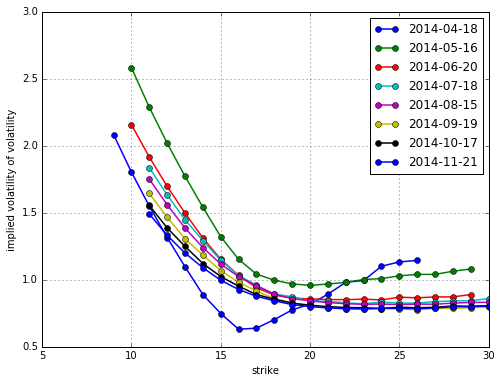

In [9]:
plot_data = options_data[options_data['IMP_VOL']>0]
maturities = sorted(set(options_data['MATURITY']))

plt.figure( figsize =( 8, 6)) 
for maturity in maturities: 
    data = plot_data[ options_data.MATURITY == maturity] 
    # select data for this maturity 
    plt.plot(data['STRIKE'], 
             data['IMP_VOL'], 
             label = maturity.date(), 
             lw = 1.5, marker = "o") 
    plt.grid(True) 
    plt.xlabel('strike') 
    plt.ylabel('implied volatility of volatility') 
    plt.legend() 

plt.show()


In [10]:
keep =['PRICE','IMP_VOL']
group_data = plot_data.groupby(['MATURITY','STRIKE'])[keep]
group_data = group_data.sum()
group_data.head()

PRICE   IMP_VOL
MATURITY   STRIKE                 
2014-04-18 9        8.85  2.083386
           10       7.85  1.804194
           11       6.85  1.550283
           12       5.85  1.316103
           13       4.85  1.097184

In [11]:
group_data.index.levels

FrozenList([[2014-04-18 00:00:00, 2014-05-16 00:00:00, 2014-06-20 00:00:00, 2014-07-18 00:00:00, 2014-08-15 00:00:00, 2014-09-19 00:00:00, 2014-10-17 00:00:00, 2014-11-21 00:00:00], [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]])